In [266]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
from math import sin, cos, radians, pi, sqrt, ceil, degrees
from collections import namedtuple
%matplotlib widget
matplotlib.rcParams['animation.ffmpeg_path'] = "/Users/kiranmclernon/Documents/PhysicsCode/ffmpeg 2"

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
plt.title('Parametric Curve Plot')
ax.set_ylabel('Y-axis')
ax.set_xlabel('X-axis')
ax.set_zlabel('Z-axis')
ax.set_yticks((-10, 10, 1.0))
ax.set_zticks((-10,10,1.0))
# Prepare arrays x, y, z
#This sets up our domain (i.e. -6pi <= t<= 6pi
t = np.linspace(-6 * np.pi, 6 * np.pi, 100)

#Now we have to write our PARAMETERIC FUNCTIONS
x = t
y = t*np.sin(t)
z = t*np.cos(t)

camera = Camera(fig)
for i in range(len(x)):
    imx = x[i]
    imy = y[i]
    imz = z[i]
    ax.scatter(x[i-1], y[i-1], z[i-1],color='blue')
    ax.plot(x[0:i], y[0:i], z[0:i],color='red',linestyle='dotted')
    camera.snap()

    
anim = camera.animate()
writervideo = animation.FFMpegWriter(fps=24)
anim.save('curveplot.mp4', writer=writervideo)

In [299]:
def lastElement(functionList):
    return functionList[len(functionList)-1]
def getElement(functionList, index):
    try:
        return functionList[index]
    except IndexError:
        return lastElement(functionList)
def getIndex(functionList,index):
    try:
        placeholder = functionList[index]
        return index
    except IndexError:
        return len(functionList)-1
class projectilePath:
    def __init__(self, time, dt, ax, ay, vx, vy, sx,sy, initialConditions):
        self.dt = dt
        self.time=np.array(time)
        self.ax =np.array(ax)
        self.ay=np.array(ay)
        self.vx=np.array(vx)
        self.vy=np.array(vy)
        self.sx=np.array(sx)
        self.sy=np.array(sy)
        self.initialConditions = initialConditions
        self.maxTime=None
class motionSim():
    class projectilemotion:
        def __init__(self, launchAngle, initialVelocity, ballRadius, mass, dt, gravity=9.81):
            self.launchAngle = radians(launchAngle)
            self.initialVelocity = initialVelocity
            self.ballRadius = ballRadius
            self.mass=mass
            self.dt=dt
            self.gravity = -abs(gravity)
        def projectileMotion(self):
            time = (-2 * self.initialVelocity*sin(self.launchAngle))/(-abs(self.gravity))
            print(f"time = {time}")
            t = np.linspace(0, time,ceil(int(1/self.dt)*time))
            sy = np.multiply(t,self.initialVelocity*sin(self.launchAngle)) + np.multiply((0.5*self.gravity),np.square(t))
            sx = self.initialVelocity*cos(self.launchAngle)*t
            vx  = np.ones(len(t))*self.initialVelocity
            vy = self.initialVelocity + self.gravity*t
            ax = np.zeros(len(t))
            ay = np.ones(len(t))*self.gravity
            return projectilePath(t,self.dt, ax,ay,vx,vy,sx,sy, self)
        def projectileMotionAirResistance(self, fluidDensity = 1.1455):
            xVelocity = [self.initialVelocity*cos(self.launchAngle)]
            yVelocity = [self.initialVelocity*sin(self.launchAngle)]
            dragConstant = 0.47*(fluidDensity)*0.5*(pi*self.ballRadius**2)
            xDisplacement = [0]
            yDisplacement = [0]
            print(f"Drag Constant is : {dragConstant}")
            ax = [0]
            ay = [0]
            
            timeList = [0]
            grounded = False
            while not grounded:
                if lastElement(timeList) > 0:
                    if lastElement(yDisplacement) <=0:
                        break
                # print(f"xVelocity: {lastElement(xVelocity)}, yVelocity: {lastElement(yVelocity)} xDisplacement: {lastElement(xDisplacement)} yDisplacememt{lastElement(yDisplacement)}, time: {lastElement(timeList)}")
                timeList.append(lastElement(timeList)+self.dt)
                xDisplacement.append(lastElement(xDisplacement)+lastElement(xVelocity)*self.dt)
                yDisplacement.append(lastElement(yDisplacement)+lastElement(yVelocity)*self.dt)
                velocityMagnitude = sqrt(lastElement(xVelocity)**2+lastElement(yVelocity)**2)
                ax.append(-dragConstant*velocityMagnitude*lastElement(xVelocity)/self.mass)
                ay.append(-abs(self.gravity)-(dragConstant*velocityMagnitude*lastElement(yVelocity)/self.mass))
                xVelocity.append(lastElement(xVelocity) + lastElement(ax)*self.dt)
                yVelocity.append(lastElement(yVelocity) +  lastElement(ay)*self.dt)
            return projectilePath(timeList, self.dt, ax,ay,xVelocity,yVelocity,xDisplacement,yDisplacement, self)
        def velocityString(self, pathName:str, path:projectilePath, index:int):
            return f"\n{pathName}: \nvx: {round(getElement(path.vx,index),2)}\nvy: {round(getElement(path.vy,index),2)}\nv mag: {round(sqrt(getElement(path.vx,index)**2+getElement(path.vy,index)**2),2)}"
        def animate(self):
            airResistancePath = self.projectileMotionAirResistance()
            airFreePath = self.projectileMotion()
            if airResistancePath.time.max() >= airFreePath.time.max():
                airResistancePath.maxTime=True
                graphTime = airResistancePath.time
            else:
                airFreePath.maxTime=True
                graphTime = airFreePath.time
            fig = plt.figure()
            gs = GridSpec(5, 10, figure=fig)
            ax1 = fig.add_subplot(gs[:, 0:7])
            # ax3 = fig.add_subplot(gs[:,5:6])
            ax2 = fig.add_subplot(gs[:, 7:])
            ax1.set_xlim(left=0,right= airFreePath.sx.max())
            ax1.set_ylim(bottom=0,top=airFreePath.sy.max())
            ax2.set_frame_on(False)
            ax2.axes.get_yaxis().set_visible(False)
            ax2.axes.get_xaxis().set_visible(False)
            # ax3.set_frame_on(False)
            # ax3.axes.get_yaxis().set_visible(False)
            # ax3.axes.get_xaxis().set_visible(False)
            camera = Camera(fig)
            annotationStringConstant = f"initial conditions:\nsphere radius: {self.ballRadius} m\nsphere mass: {self.mass} kg\ninitial velocity: {self.initialVelocity} m/s\nlaunch angle: {degrees(self.launchAngle)} degrees"
            for i in range(len(graphTime)):
                ax1.scatter(airFreePath.sx[:getIndex(airFreePath.sx,i)],airFreePath.sy[:getIndex(airFreePath.sy,i)],color='red')
                ax1.scatter(airResistancePath.sx[:getIndex(airResistancePath.sx,i)],airResistancePath.sy[:getIndex(airResistancePath.sy,i)],color='blue')
                vaccuumString = self.velocityString(pathName="vacuum projectile", path=airFreePath, index=i)
                airResistanceString = self.velocityString(pathName="air resistance projectile", path=airResistancePath, index=i)
                ax2.text(0,(airFreePath.sy.max()/2),s=(annotationStringConstant+vaccuumString+airResistanceString ))
                camera.snap()
            plt.show()
            anim = camera.animate(interval=1000000*self.dt)
            writervideo = animation.FFMpegWriter(fps=24)
            anim.save('projectileMotion.mp4', writer=writervideo)      
            



Drag Constant is : 0.8456931804014703
time = 0.7208020195581524


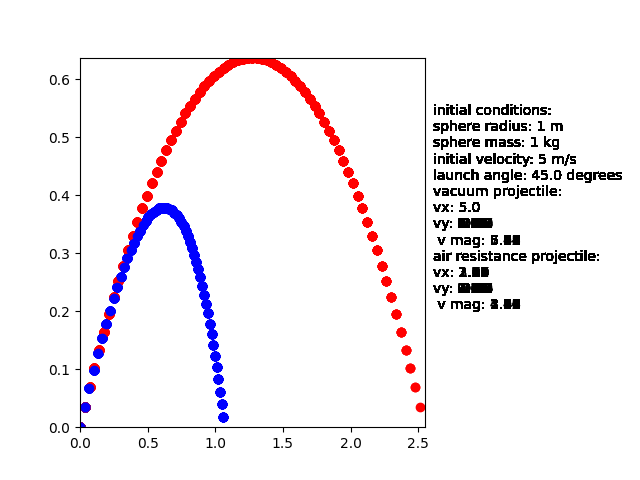

In [303]:
sim = motionSim.projectilemotion(launchAngle=45, initialVelocity=5, ballRadius=1, mass=1, dt=0.01)
sim.animate()